In [1]:
import numpy as np
import time as time
import matplotlib.pyplot as plt
from feature_extraction import OCR_raw_data, OCR_feature_data, face_raw_data, face_feature_data

Two-Layer Neural Network on digit OCR and Face Detection

In [2]:
class TwoLayerNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.inBias = input_size+1
        self.hidden_size = hidden_size
        self.hidBias = hidden_size+1
        self.output_size = output_size
        W1 = np.random.randn(self.hidden_size, self.inBias)
        W1 = W1.flatten()
        W2 = np.random.randn(self.output_size, self.hidBias)
        W2 = W2.flatten()
        self.weights = np.concatenate((W1,W2))
        L1_grads = np.zeros((self.hidden_size, self.inBias))
        L2_grads = np.zeros((self.output_size, self.hidBias))
        self.gradients = np.concatenate((L1_grads.flatten(),L2_grads.flatten()))
        self.model = (self.input_size, self.inBias, self.hidden_size, self.hidBias, self.output_size, self.weights, self.gradients)
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    def forward_propagation(self, X):
        weights = self.model[5]
        inBias = self.model[1]
        hidBias = self.model[3]
        hidden_size = self.model[2]
        output_size = self.model[4]

        W1 = np.reshape(weights[0:inBias*hidden_size],(hidden_size,inBias))
        W2 = np.reshape(weights[inBias*hidden_size:],(output_size,hidBias))
        #W1 = np.reshape(self.weights[0:self.inBias*self.hidden_size],(self.hidden_size,self.inBias))
        #W2 = np.reshape(self.weights[self.inBias*self.hidden_size:],(self.output_size,self.hidBias))
        # First layer
        A1 = np.insert(X, 0, 1, axis=0)
        Z2 = np.dot(W1, A1)
        A2 = self.sigmoid(Z2)
        # Second layer
        A2 = np.insert(A2, 0, 1, axis=0)
        Z3 = np.dot(W2, A2)
        A3 = self.sigmoid(Z3) 
        cache = {"Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3, "A1": A1}
        
        return A3, cache
    
    def backward_propagation(self, Y, cache):
        weights = self.model[5]
        inBias = self.model[1]
        hidBias = self.model[3]
        hidden_size = self.model[2]
        output_size = self.model[4]
        gradients = self.model[6]
        W2 = np.reshape(weights[inBias*(hidden_size):],(output_size,hidBias))
        #W2 = np.reshape(self.weights[self.inBias*(self.hidden_size):],(self.output_size,self.hidBias))
        A1 = cache["A1"]
        A2 = cache["A2"]
        A2_B = A2[1:]
        A3 = cache["A3"]
        y=np.array(Y)
        encode_Y = np.eye(output_size)[y.astype(int)]
        #dZ3 = A3 - encode_Y
        dZ3 = self.softmax(A3) - encode_Y
        W2_B = W2[:,1:]
        dZ2 = np.dot(W2_B.T, dZ3) * (A2_B * (1 - A2_B))
        L1_grads = np.reshape(gradients[0:inBias*hidden_size],(hidden_size,inBias))
        g = dZ2[:, np.newaxis] * A1
        L1_grads += g
        L2_grads = np.reshape(gradients[inBias*hidden_size:],(output_size,hidBias))
        #L2_grads = np.reshape(self.gradients[self.inBias*self.hidden_size:],(self.output_size,self.hidBias))
        g2 = dZ3[:, np.newaxis] * A2 
        L2_grads += g2
        grads = [L1_grads, L2_grads]
        return grads   
    def update_parameters(self,grads, learning_rate, n):
        weights = self.model[5]
        inBias = self.model[1]
        hidBias = self.model[3]
        hidden_size = self.model[2]
        output_size = self.model[4]

        W1 = np.reshape(weights[0:inBias*hidden_size],(hidden_size,inBias))
        #W1 = np.reshape(weights[0:self.inBias*self.hidden_size],(self.hidden_size,self.inBias))
        W2 = np.reshape(weights[inBias*hidden_size:],(output_size,hidBias))
        #W2 = np.reshape(weights[self.inBias*self.hidden_size:],(self.output_size,self.hidBias))
        L1_grads = grads[0]
        L2_grads = grads[1]

        dW1 = (L1_grads/n) 
        dW1[:,1:] += 0.001*(W1[:,1:])
        

        dW2 = (L2_grads/n) 
        dW2[:,1:] += 0.001*W2[:,1:]
       

        W1 = W1 - learning_rate * dW1
        W2 = W2 - learning_rate * dW2
       


        self.weights = np.concatenate((W1.flatten(),W2.flatten()))
        self.gradients = np.concatenate((L1_grads.flatten(),L2_grads.flatten()))
        self.model = (self.input_size, self.inBias, self.hidden_size, self.hidBias, self.output_size, self.weights, self.gradients)
    
    def fit(self, X, Y, learning_rate):
        n = len(Y)
        correct = 0
        self.gradients = np.zeros(self.gradients.shape)    
        for j in range(X.shape[0]):

            x = X[j]
            y = Y[j]
            A3, cache = self.forward_propagation(x)
            if self.output_size == 2:
                if self.softmax(A3)[1] > 0.5:
                    prediction = 1
                else:
                    prediction = 0
                if prediction == y:
                    correct += 1
                    continue
            else:
                if np.argmax(self.softmax(A3)) == y:
                    correct += 1
                    continue
            
            grads = self.backward_propagation(y, cache)
            
            self.update_parameters(grads, learning_rate,n)
        return correct/n, self.model
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # Subtracting max(x) for numerical stability
        return exp_x / exp_x.sum(axis=0)

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            x = X[i]
            A3, _ = self.forward_propagation(x)
            softA3 = self.softmax(A3)
            if self.output_size == 2:
                if softA3[1] > 0.5:
                    prediction = 1
                else:
                    prediction = 0
            else:
                prediction = np.argmax(softA3)
            predictions.append(prediction)
        return predictions


Select Training Data Helper Function

In [3]:
def process_data(xTrain, yTrain, n):
    num_rows = xTrain.shape[0]
    num_select =  int(num_rows*n)
    selected_indices = np.random.choice(num_rows, num_select, replace=False)
    x = [xTrain[index] for index in selected_indices]
    y = [yTrain[index] for index in selected_indices]
    xTrain = np.array(x)
    yTrain = np.array(y)
    return xTrain, yTrain

In [4]:
def OneNNSet(xTrain, yTrain, xValid, yValid, xTest, yTest, learning_rate, hidden_size, output_size, epochs, n, abandon):
    import time as time
    import math as math
    if n < 1.0:
        xTrain, yTrain = process_data(xTrain, yTrain, n)
    input_size = xTrain.shape[1]
    neural = TwoLayerNN(input_size, hidden_size, output_size)
    accuracy = []
    validAcc = []
    models = []
    max = 0
    maxCount = 0
    start_time = time.time()
    for i in range(epochs):
        trainAcc, model = neural.fit(xTrain, yTrain, learning_rate)
        models.append(model)
        vali_predictions = neural.predict(xValid)
        #test_predictions = neural.predict(xTest)
        CorrectPredictionCount = 0
        for j in range(len(vali_predictions)):
            if vali_predictions[j] == yValid[j]:
                CorrectPredictionCount += 1
        vali_accuracy = CorrectPredictionCount/len(vali_predictions)
        validAcc.append(vali_accuracy)
        if  validAcc[i] > max :
            max = validAcc[i]
            maxCount = 0
        else:
            maxCount += 1
        if maxCount == abandon:
            #accuracy = accuracy[:-abandon]
            validAcc = validAcc[:-abandon]
            models = models[:-abandon]
            break
        """
        CorrectPredictionCount = 0
        for k in range(len(test_predictions)):
            if test_predictions[k] == yTest[k]:
                CorrectPredictionCount += 1
        test_accuracy = CorrectPredictionCount/len(test_predictions)
        """
        print(f'Epoch: {i+1} Train Accuracy: {trainAcc*100:.2f}% Validation Accuracy: {vali_accuracy*100:.2f}%')
        #print(f'Epoch: {i+1} Train Accuracy: {trainAcc*100:.2f}% Validation Accuracy: {vali_accuracy*100:.2f}% Test Accuracy: {test_accuracy*100:.2f}%')
        #accuracy.append(test_accuracy)
    end_time = time.time()
    elasped_time = end_time - start_time
    index = np.argmax(validAcc)
    #print(f'Best Validation Accuracy: {validAcc[index]*100:.2f}%')
    best_model = models[index]
    neural.model = best_model
    test_predictions = neural.predict(xTest)
    CorrectPredictionCount = 0
    for k in range(len(test_predictions)):
        if test_predictions[k] == yTest[k]:
            CorrectPredictionCount += 1
    test_accuracy = CorrectPredictionCount/len(test_predictions)
    print(f'Testing Accuracy: {test_accuracy*100:.2f}%')
    #worst model
    """
    index = np.argmin(validAcc)
    print(f'Worst Validation Accuracy: {validAcc[index]*100:.2f}%')
    worst_model = models[index]
    neural.model = worst_model
    test_predictions = neural.predict(xTest)
    CorrectPredictionCount = 0
    for k in range(len(test_predictions)):
        if test_predictions[k] == yTest[k]:
            CorrectPredictionCount += 1
    worst_test_accuracy = CorrectPredictionCount/len(test_predictions)
    print(f'Worst Testing Accuracy: {worst_test_accuracy*100:.2f}%')
    neural.model = best_model
    mean_accuracy = np.mean(accuracy)*100
    std_accuracy = np.std(accuracy)*100
    print(f'Time taken: {elasped_time:.2f} seconds')
    print(f'Average OCR Accuracy: {mean_accuracy:.2f}%')
    print(f'Standard Deviation OCR Accuracy: {std_accuracy:.2f}%')
    """
    return elasped_time, test_accuracy, neural

In [5]:
training_sets = [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9, 1.0]

OCR

In [6]:
OCRtrainImg = "digitdata/trainingimages"
OCRtrainLabel = "digitdata/traininglabels"

OCRvalidImg = "digitdata/validationimages"
OCRvalidLabel = "digitdata/validationlabels"

OCRtestImg = "digitdata/testimages"
OCRtestLabel = "digitdata/testlabels"
"""
X_train_Ocr, Y_train_Ocr = OCR_raw_data(OCRtrainImg, OCRtrainLabel)
X_valid_Ocr, Y_valid_Ocr = OCR_raw_data(OCRvalidImg, OCRvalidLabel)
X_test_Ocr, Y_test_Ocr = OCR_raw_data(OCRtestImg, OCRtestLabel)
"""
X_train_Ocr, Y_train_Ocr = OCR_feature_data(OCRtrainImg, OCRtrainLabel, 2, 2)
X_valid_Ocr, Y_valid_Ocr = OCR_feature_data(OCRvalidImg, OCRvalidLabel, 2, 2)
X_test_Ocr, Y_test_Ocr= OCR_feature_data(OCRtestImg, OCRtestLabel, 2, 2)


print(X_train_Ocr.shape)
print(len(Y_train_Ocr))
print(X_valid_Ocr.shape)
print(len(Y_valid_Ocr))
print(X_test_Ocr.shape)
print(len(Y_test_Ocr))

(5000, 196)
5000
(1000, 196)
1000
(1000, 196)
1000


Training set size: 10%
Iteration: 1
Epoch: 1 Train Accuracy: 21.00% Validation Accuracy: 36.70%
Epoch: 2 Train Accuracy: 48.60% Validation Accuracy: 45.40%
Epoch: 3 Train Accuracy: 66.00% Validation Accuracy: 63.60%
Epoch: 4 Train Accuracy: 77.60% Validation Accuracy: 68.50%
Epoch: 5 Train Accuracy: 78.20% Validation Accuracy: 66.80%
Epoch: 6 Train Accuracy: 75.00% Validation Accuracy: 64.90%
Epoch: 7 Train Accuracy: 76.20% Validation Accuracy: 64.90%
Epoch: 8 Train Accuracy: 76.60% Validation Accuracy: 65.70%
Testing Accuracy: 66.60%

Iteration: 2
Epoch: 1 Train Accuracy: 23.80% Validation Accuracy: 32.40%
Epoch: 2 Train Accuracy: 61.80% Validation Accuracy: 58.30%
Epoch: 3 Train Accuracy: 70.80% Validation Accuracy: 60.00%
Epoch: 4 Train Accuracy: 82.60% Validation Accuracy: 69.90%
Epoch: 5 Train Accuracy: 85.40% Validation Accuracy: 68.60%
Epoch: 6 Train Accuracy: 84.80% Validation Accuracy: 66.60%
Epoch: 7 Train Accuracy: 84.00% Validation Accuracy: 67.60%
Epoch: 8 Train Accuracy: 

/var/folders/b_/ybg5r8x93hj0c9sh9z04nrzh0000gn/T/ipykernel_53846/702355395.py:18: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


Epoch: 12 Train Accuracy: 75.53% Validation Accuracy: 69.80%
Testing Accuracy: 69.30%

Iteration: 4
Epoch: 1 Train Accuracy: 31.80% Validation Accuracy: 56.40%
Epoch: 2 Train Accuracy: 70.27% Validation Accuracy: 69.60%
Epoch: 3 Train Accuracy: 76.20% Validation Accuracy: 61.30%
Epoch: 4 Train Accuracy: 69.47% Validation Accuracy: 66.50%
Epoch: 5 Train Accuracy: 71.13% Validation Accuracy: 67.90%
Epoch: 6 Train Accuracy: 74.33% Validation Accuracy: 66.30%
Testing Accuracy: 70.50%

Iteration: 5
Epoch: 1 Train Accuracy: 34.67% Validation Accuracy: 57.40%
Epoch: 2 Train Accuracy: 66.00% Validation Accuracy: 69.50%
Epoch: 3 Train Accuracy: 71.93% Validation Accuracy: 59.70%
Epoch: 4 Train Accuracy: 70.20% Validation Accuracy: 67.00%
Epoch: 5 Train Accuracy: 68.67% Validation Accuracy: 64.20%
Epoch: 6 Train Accuracy: 69.47% Validation Accuracy: 61.00%
Testing Accuracy: 64.60%

Mean Time: 5.66 seconds - Mean Accuracy: 69.48% - Standard Deviation: 2.61%
Training set size: 40%
Iteration: 1
Epo

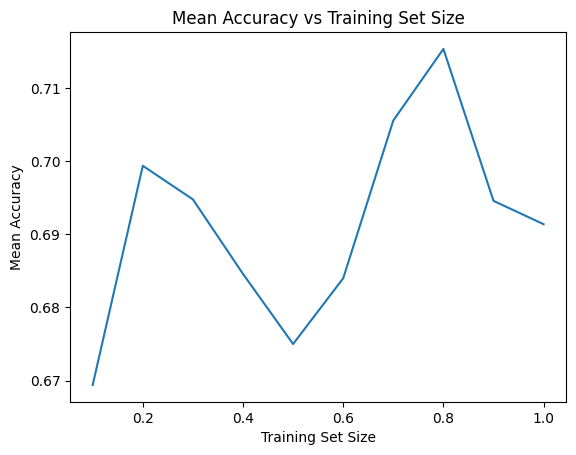

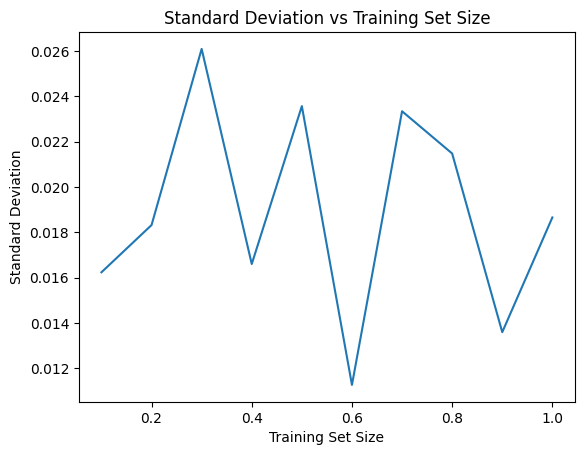

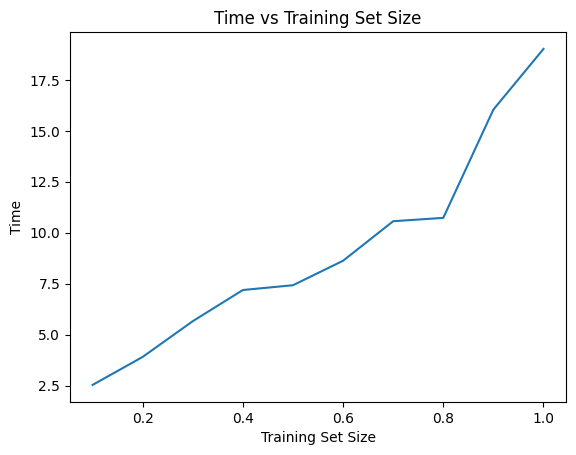

In [7]:
timesOcrArr = []
meanAccOcrArr = []
stdAccOcrArr = []
neuralsOCR = []
for n in training_sets:
    setTimes = []
    setAcc = []
    print(f'Training set size: {n*100:.0f}%')
    for i in range(5):
        print(f'Iteration: {i+1}')
        time, acc, model = OneNNSet(X_train_Ocr, Y_train_Ocr, X_valid_Ocr, Y_valid_Ocr, X_test_Ocr, Y_test_Ocr, 0.1, 128, 10, 50, n ,5)
        setTimes.append(time)
        setAcc.append(acc)
        neuralsOCR.append(model)
        print("")
    meanTime = np.mean(setTimes)
    meanAcc = np.mean(setAcc)
    stdAcc = np.std(setAcc)
    print(f'Mean Time: {meanTime:.2f} seconds - Mean Accuracy: {meanAcc*100:.2f}% - Standard Deviation: {stdAcc*100:.2f}%')
    timesOcrArr.append(meanTime)
    meanAccOcrArr.append(meanAcc)
    stdAccOcrArr.append(stdAcc)

plt.plot(training_sets, meanAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Training Set Size')
plt.show()

plt.plot(training_sets, stdAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Training Set Size')
plt.show()

plt.plot(training_sets, timesOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Time')
plt.title('Time vs Training Set Size')
plt.show()


In [8]:
xDemoTest_OCR, yDemoTest_OCR = process_data(X_test_Ocr, Y_test_Ocr, 1.0)
OCR_test_predictions = neuralsOCR[-1].predict(xDemoTest_OCR)
CorrectPredictionCount = 0
for k in range(len(OCR_test_predictions)):
    if OCR_test_predictions[k] == yDemoTest_OCR[k]:
        CorrectPredictionCount += 1
test_accuracy = CorrectPredictionCount/len(OCR_test_predictions)
print(f'Final OCR Test Accuracy: {test_accuracy*100:.2f}%')

Final OCR Test Accuracy: 67.80%


Face Detection

In [9]:
FaceTrainImg = "facedata/facedatatrain"
FaceTrainLabel = "facedata/facedatatrainlabels"

FaceValidImg = "facedata/facedatavalidation"
FaceValidLabel = "facedata/facedatavalidationlabels"

FaceTestImg = "facedata/facedatatest"
FaceTestLabel = "facedata/facedatatestlabels"
"""
X_train_Face, Y_train_Face = face_raw_data(FaceTrainImg, FaceTrainLabel)
X_valid_Face, Y_valid_Face = face_raw_data(FaceValidImg, FaceValidLabel)
X_test_Face, Y_test_Face = face_raw_data(FaceTestImg, FaceTestLabel)
"""

X_train_Face, Y_train_Face = face_feature_data(FaceTrainImg, FaceTrainLabel, 2, 2)
X_valid_Face, Y_valid_Face = face_feature_data(FaceValidImg, FaceValidLabel, 2, 2)
X_test_Face, Y_test_Face = face_feature_data(FaceTestImg, FaceTestLabel, 2, 2)

print(X_train_Face.shape)
print(len(Y_train_Face))
print(X_valid_Face.shape)
print(len(Y_valid_Face))
print(X_test_Face.shape)
print(len(Y_test_Face))


(451, 1050)
451
(301, 1050)
301
(150, 1050)
150


Training set size: 10%
Epoch: 1 Train Accuracy: 37.78% Validation Accuracy: 50.83%
Epoch: 2 Train Accuracy: 73.33% Validation Accuracy: 53.82%
Epoch: 3 Train Accuracy: 73.33% Validation Accuracy: 56.15%
Epoch: 4 Train Accuracy: 91.11% Validation Accuracy: 57.14%
Epoch: 5 Train Accuracy: 80.00% Validation Accuracy: 50.83%
Epoch: 6 Train Accuracy: 80.00% Validation Accuracy: 55.15%
Epoch: 7 Train Accuracy: 95.56% Validation Accuracy: 59.14%
Epoch: 8 Train Accuracy: 97.78% Validation Accuracy: 59.14%
Epoch: 9 Train Accuracy: 100.00% Validation Accuracy: 59.14%
Epoch: 10 Train Accuracy: 100.00% Validation Accuracy: 59.14%
Epoch: 11 Train Accuracy: 100.00% Validation Accuracy: 59.14%
Testing Accuracy: 66.67%

Epoch: 1 Train Accuracy: 48.89% Validation Accuracy: 50.17%
Epoch: 2 Train Accuracy: 71.11% Validation Accuracy: 49.17%
Epoch: 3 Train Accuracy: 86.67% Validation Accuracy: 49.17%
Epoch: 4 Train Accuracy: 100.00% Validation Accuracy: 49.17%
Epoch: 5 Train Accuracy: 100.00% Validation A

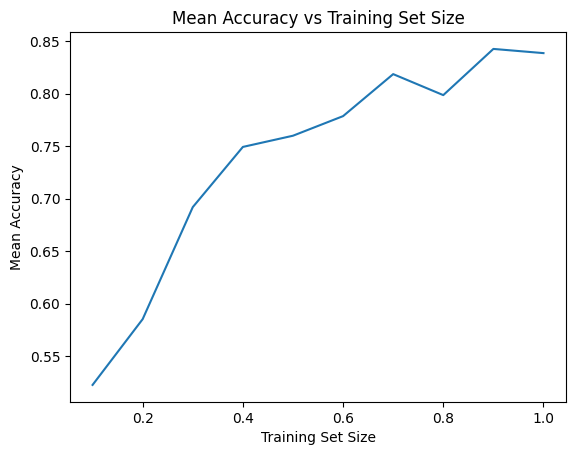

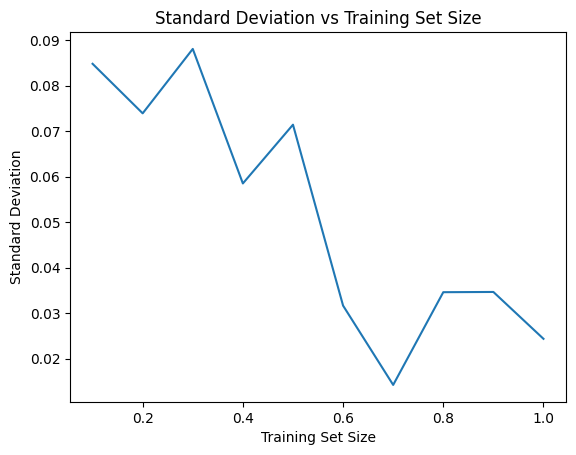

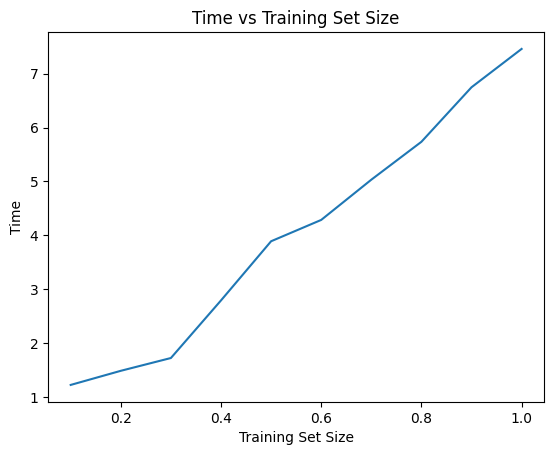

In [10]:
timesFaceArr = []
meanAccFaceArr = []
stdAccFaceArr = []
neuralsFace = []
for n in training_sets:
    setTimes = []
    setAcc = []
    print(f'Training set size: {n*100:.0f}%')
    for i in range(5):
        times,acc, model = OneNNSet(X_train_Face, Y_train_Face,X_valid_Face,Y_valid_Face, X_test_Face, Y_test_Face, 0.1, 256, 2, 50, n, 5)
        setTimes.append(times)
        setAcc.append(acc)
        neuralsFace.append(model)
        print("")
    meanTime = np.mean(setTimes)
    meanAcc = np.mean(setAcc)
    stdAcc = np.std(setAcc)
    print(f'Mean Time: {meanTime:.2f} seconds - Mean Accuracy: {meanAcc*100:.2f}% - Standard Deviation: {stdAcc*100:.2f}%')
    timesFaceArr.append(meanTime)
    meanAccFaceArr.append(meanAcc)
    stdAccFaceArr.append(stdAcc)


plt.plot(training_sets, meanAccFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Training Set Size')
plt.show()

plt.plot(training_sets, stdAccFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Training Set Size')
plt.show()

plt.plot(training_sets, timesFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Time')
plt.title('Time vs Training Set Size')
plt.show()



In [11]:
X_demo_test_Face, y_demo_test_Face = process_data(X_test_Face, Y_test_Face, 1.0)
Face_test_predictions = neuralsFace[-1].predict(X_demo_test_Face)
CorrectPredictionCount = 0
for k in range(len(Face_test_predictions)):
    if Face_test_predictions[k] == y_demo_test_Face[k]:
        CorrectPredictionCount += 1
test_accuracy = CorrectPredictionCount/len(Face_test_predictions)
print(f'Final Face Test Accuracy: {test_accuracy*100:.2f}%')



Final Face Test Accuracy: 83.33%
